## Detector probabilities over a call

In [1]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from marine_acoustics.configuration import intro
from marine_acoustics.data_processing import info, read, sample, features, label, make_dataset
from marine_acoustics.model import train, predict
from marine_acoustics.results import evaluate, spectrogram
from marine_acoustics.configuration import settings as s

# Change cwd
os.chdir(r'C:\Users\james\OneDrive - Nexus365\Engineering\Year4\4YP\git\marine_acoustics')

%matplotlib inline


### Choose a specific call

In [2]:
# ---------------------------
SITE = 5
# ---------------------------
CALLS = [3]
# ---------------------------
WAVFILE = '20150303_150000'
# ---------------------------
TIME = '2015/3/3  15:02:24.517'      # Note the date time has TWO spaces between
# ---------------------------
PADDING = 4                           # Pad the call selection with this number of frames
# ---------------------------

site = info.get_recording_sites()[SITE-1]
call_types = info.get_call_types()
call_types = [call_types[i-1] for i in CALLS]
wavfile = WAVFILE + '.wav'
print(site, ':', call_types, ':', wavfile)

S Kerguelen 2015 : ['Bm-Z'] : 20150303_150000.wav


In [3]:
# Folder structure
df_folder_structure = info.get_folder_structure()

# Combine all call-type logs
df_logs = sample.concat_call_logs(site, call_types, df_folder_structure)

# Groupby .wav filename
gb_wavfile = df_logs.groupby('Begin File')
logs = gb_wavfile.get_group(wavfile)

# Read audio
y_raw, sr_default = read.read_audio(site, wavfile, df_folder_structure)

# Frame and extract features
y_features = features.extract_features(y_raw)

# Label features
y_labelled_features = label.label_features(y_features, logs, sr_default)
y_labels = np.asarray([sample[1] for sample in y_labelled_features])

# Get log corresponding to selected call
call_log = logs.loc[logs['Begin Date Time'] == TIME]

# Get the sample indexes of start/end of whale calls
call_indexes = label.get_call_indexes(call_log, sr_default)

# Convert call indexes to frame indexes
frame_indexes = label.index2frame(call_indexes)

# Selected call frame indexes with padding
frame_indexes = [frame_indexes[0][0]-PADDING, frame_indexes[0][1]+PADDING]


In [4]:
# Ground truth
y_test = y_labels[np.arange(frame_indexes[0], frame_indexes[1]+1)]
y_test = [0 if i==0 else 1 for i in y_test]

# Features
X_test = y_features[np.arange(frame_indexes[0], frame_indexes[1]+1),:]


In [5]:
%%capture

y_test_proba = []

for i in range(3):

    s.TRAIN_CALL_TYPES = [i+1]
    
    # Extract and save train and test sets
    make_dataset.make_dataset()
    
    # Train model
    model = train.train_classifier()

    # Predictions
    y_test_proba.append(model.predict_proba(X_test)[:,1])


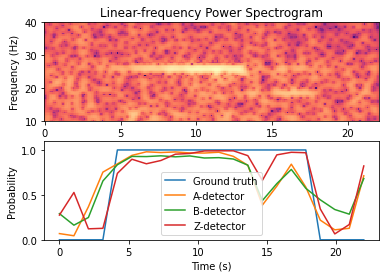

In [6]:
# Select a slice of the audio (seconds)
t_start = round(call_log.iloc[0]['Beg File Samp (samples)']/sr_default - PADDING*s.FRAME_ADVANCE/1000) 
t_end = round(call_log.iloc[0]['End File Samp (samples)']/sr_default + PADDING*s.FRAME_ADVANCE/1000)

# Plot
y = y_raw[s.SR*t_start:s.SR*t_end]
ylim = [10, 40]
plt.subplot(2,1,1)
spectrogram.plot_spectrogram(y, ylim)

#Plot ground truth
t = np.linspace(0, t_end-t_start, num=len(y_test))

plt.subplot(2,1,2)
plt.plot(t, y_test)
plt.plot(t, y_test_proba[0])
plt.plot(t, y_test_proba[1])
plt.plot(t, y_test_proba[2])
plt.ylim([0, 1.1])
plt.ylabel('Probability')
plt.xlabel('Time (s)')
plt.legend(['Ground truth', 'A-detector', 'B-detector', 'Z-detector']);
